In [4]:
import numpy as np
from copy import copy
import cvxpy as cvx
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import imageio
from sklearn.svm import SVR, LinearSVR
from sklearn.model_selection import GridSearchCV
import pandas as pd
import seaborn
import scipy
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [59]:
np.random.seed(10)
large_df = pd.DataFrame(columns=['problem_value', 'mean_r.value'])
# f-statistic
# fstat = np.random.uniform(1,100,(144,4))
# cov = np.random.uniform(1,100,(10,4))
inputs_ = np.random.normal(1,20,200)
inputs = inputs_.copy()
# corr, corr2 = pd.DataFrame(np.random.uniform(1,100,(200,100))), pd.DataFrame(np.random.uniform(1,100,(120,100)))
# chi-squared
# corr, corr2 = None, None
# corr, corr2 = pd.DataFrame(np.random.uniform(1,3,(120,120))), pd.DataFrame(np.random.uniform(1,3,(120,120)))
# mahalanobis
corr, corr2 = pd.DataFrame(np.random.uniform(1,100,(120,120))), pd.DataFrame(np.random.uniform(1,100,(120,120)))
# input_index = corr2.index.astype(np.int64).values
# f-statistic
# yrj = np.matmul(corr2.T.corr('spearman').replace(np.nan, 0).values,corr2.values) # 144 x 4
# chi-squared
# yrj = corr.values * corr2.values # 144 x 144
# mahalanobis
yrj = np.sqrt(np.square(np.matmul(corr.T.values,np.linalg.inv(np.cov(corr2.T.values)), corr.values))) # 144 x 144
mean_r = cvx.Variable((corr2.values.shape[0],100))
yro = corr2.values
xio = inputs
xij = np.random.normal(1,100,(200,100))
vi = cvx.Variable((inputs.shape[0],1))
objective = cvx.Minimize(cvx.sum(cvx.matmul(mean_r.T, yro)))
constraints = [(cvx.sum(cvx.matmul(xij.T,vi).T)-cvx.sum(cvx.matmul(mean_r.T, yrj))) <= 0,
               mean_r >= 0,cvx.matmul(vi.T, xio)==1]
problem = cvx.Problem(objective, constraints)
problem.solve(verbose=True, solver=cvx.SCS, max_iters=1000)
df = pd.DataFrame(mean_r.value, columns=np.arange(mean_r.value.shape[1]))
df['problem_value'] = [problem.value]*mean_r.value.shape[0]
# df['corr2_index'] = input_index
large_df = pd.concat([large_df,df], axis=0)
large_df = large_df.reset_index()

# seaborn.distplot(inputs_)

## f statistical value

f_value = 0.0
between_group = 4 * ((yro.mean(axis=0) - yro.mean())**2).sum() * 4 / 3
within_group = xio.var(axis=0).sum() * 10/(10-1)
f_value = between_group / within_group
print("f_value: ", f_value)

WARN: m less than n, problem likely degenerate
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 24400
eps = 1.00e-04, alpha = 1.50, max_iters = 1000, normalize = 1, scale = 1.00
acceleration_lookback = 0, rho_x = 1.00e-03
Variables n = 12200, constraints m = 12002
Cones:	primal zero / dual free vars: 1
	linear vars: 12001
WARN: aa_init returned NULL, no acceleration applied.
Setup time: 3.86e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.58e+05  6.86e+01  1.12e-01 -1.26e-01  2.04e-06  2.75e-17  3.08e-02 
   100| 1.33e+03  4.63e-01  2.77e-06  2.77e-06  2.69e-11  2.18e

<AxesSubplot:>

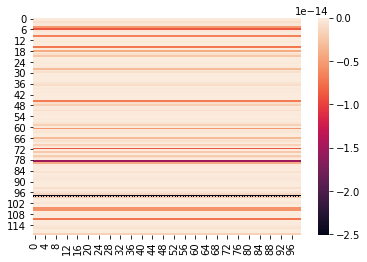

In [62]:
seaborn.heatmap(m[:,:,0])

<AxesSubplot:>

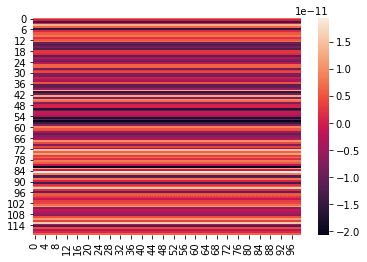

In [63]:
seaborn.heatmap(m[:,:,1])

<AxesSubplot:>

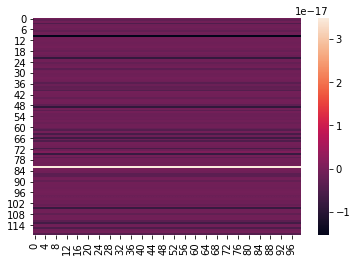

In [64]:
seaborn.heatmap(m[:,:,2])

In [ ]:
seaborn.distplot(vi.value)

In [ ]:
f_value = 0.0
between_group = 4 * ((yro.mean(axis=0) - yro.mean())**2).sum() * 4 / 3
within_group = xio.var(axis=0).sum() * 10/(10-1)
f_value = between_group / within_group
import matplotlib.pyplot as plt
plt.title("f_value: " + str(f_value))
seaborn.distplot(mean_r.value)

In [ ]:
# alternative hypothesis saying it is dependent between input and DMU (s)
chi_value = 0.0
observed = xio.reshape(-1,1)
expected = xij
chi_value = ((observed - expected)**2 / expected).sum() * 1 / 4
import matplotlib.pyplot as plt
plt.title("chi_value: " + str(chi_value))
seaborn.distplot(mean_r.value)

In [ ]:
t_score = (yro.mean() - xio.mean()) / (yro.std()*144/143)
import matplotlib.pyplot as plt
plt.title("t_score: " + str(t_score))
seaborn.distplot(mean_r.value)

In [ ]:
f_value = 0.0
between_group = 4 * ((yro.mean(axis=0) - yro.mean())**2).sum() * 4 / 3
within_group = xio.var(axis=0).sum() * 10/(10-1)
f_value = between_group / within_group
import matplotlib.pyplot as plt
plt.title("f_value: " + str(f_value))
seaborn.distplot(large_df['mean_r.value'])

In [ ]:
# alternative hypothesis saying it is dependent between input and DMU (s)
chi_value = 0.0
observed = xio.reshape(-1,1)
expected = xij
chi_value = ((observed - expected)**2 / expected).sum() * 1 / 4
import matplotlib.pyplot as plt
plt.title("chi_value: " + str(chi_value))
seaborn.distplot(large_df['mean_r.value'])

#### F-stat example

In [ ]:
inputs_, vi.value, xij, yrj, yro

In [ ]:
from scipy.stats import chisquare
chisquare(np.random.normal(0.1,0.4,100), 
      f_exp=[np.ones(100), 
        np.ones(100)*1.01, np.ones(100)*1.02, np.ones(100)*1.03, 
        np.ones(100)*1.04, np.ones(100)*1.05, np.ones(100)*1.06, np.ones(100)*1.07], axis=1)